In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import re

## General data organization

In [3]:
df = pd.read_csv("student_responses.csv")

# rename column headers to be more succinct
df.columns = ["timestamp",
              "course",                             # Q1
              "how did you learn about comp bio?",  # Q2
              "courses w/ comp bio",                # Q3
              "time on comp bio",                   # Q4
              "instructor support",                 # Q5
              "course resource support",            # Q6
              "most helpful",                       # Q7
              "frustrations",                       # Q8
              "add. info",                          # Q9
              "graduating",                         # Q10
              "job app/acceptance impact",          # Q11
              "career plan impact",                 # Q12
              "demographics",                       # Q13
              "email"]                              # Q14

df.insert(0, "ID", df.index, False)

Each respondent's unique identifier is the corresponding row's index.

## Individual questions
### Question 1
Standardize course codes:

In [4]:
# regexes to look for
subject_pattern = re.compile("[A-Za-z]{4}")         # e.g., "BSCI" or "BIOE"
number_pattern = re.compile("[0-9]{3}[A-Za-z]?")    # e.g., "171" or "330"

# iterate through each response in "course" column and standardize course codes
for i in range(len(df["course"])):
    subject = subject_pattern.search(df["course"][i]).group().upper() if subject_pattern.search(df["course"][i]) else ""
    number = number_pattern.search(df["course"][i]).group().upper() if number_pattern.search(df["course"][i]) else ""

    df.at[i, "course"] = subject + number   # update course code to standard (e.g., biol708w -> BIOL708W)

### might have to modify data a bit more. it's obvious some respondents mistyped their course codes
### (e.g., BSCI708W when they meant BIOL708W or BSCI331 when they meant BSCI330).

Generate bar chart of course data:

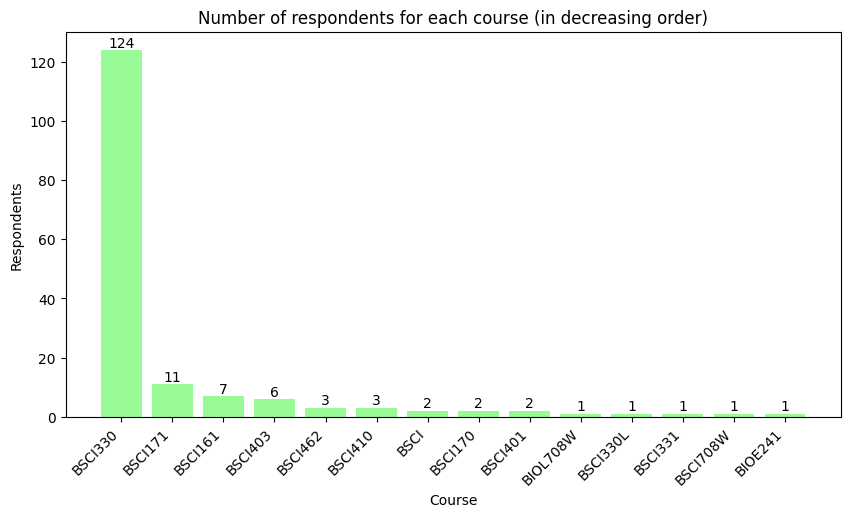

In [15]:
count = df["course"].value_counts() # y-values -- number of respondents for each course
courses = count.index.tolist()      # x-values -- courses

# generate bar chart
plt.figure(figsize=(10, 5))
plt.bar(courses, count, color="palegreen")

# display values above each bar
for i in range(len(courses)):
    plt.text(i, count.iloc[i], count.iloc[i], ha="center", va="bottom")

plt.title("Number of respondents for each course (in decreasing order)")
plt.xlabel("Course")
plt.ylabel("Respondents")
plt.xticks(rotation=45, ha="right")

plt.show()